### Bayesian optimization with slopt


#### What is the Multi-armed bandid problem


https://en.wikipedia.org/wiki/Multi-armed_bandit


- Assume you enter in a Casino and there are several machines (bandids) you can play.

- Assume you would like to maximize the money you make at the casino.

- There are several actions you can make $\{1,\dots,K\}$ (machines you can play).

- There is a reward $x(t) \in [0,1]^k$.

- There is a  $\text{regret} = \text{reward} - \text{reward_of_best_action}$ 

- There is a sequence of trials $t = 1,2,\dots, T$


#### Exploration and Exploitation dilema

What happens if a action


In [1]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
noise_level = 0.05

def f(x, noise_level=noise_level, random_state=123):
    #np.random.seed(random_state)
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

- In skopt the function $f$ is assumed to take as input a vector ${x}$ represented as a `np.array` and to return a scalar $f(x)$.

In [3]:
np.random.rand(4)

array([0.69646919, 0.28613933, 0.22685145, 0.55131477])

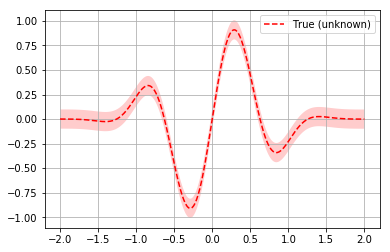

In [4]:
x = np.linspace(-2, 2, 400).reshape(-1, 1)

fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")

plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

plt.legend()
plt.grid()
plt.show()

In [6]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=40)         # the number of evaluations of f 
                  #n_random_starts=5,  # the number of random initialization points
                  #noise=0.1**2,       # the noise level (optional)
                  #random_state=123)   # the random seed

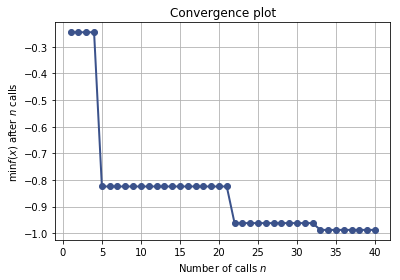

In [7]:
from skopt.plots import plot_convergence
plot_convergence(res);

#### About the result


- `res.x`: is the input space point with best (lowest) objective function. Usually written as $x^*$.


- `res.fun`: is $f(x^*)$, the lowest objective function found.


- `res.x_iters`: list containing all $N$ values $x^1,\dots,x^N$ tested.


- `res.func_vals`:  list containing all the objective values $f(x^1),\dots,f(x^N)$ of the $N$ points $x^1,\dots,x^N$ tested.



In [21]:
res.keys()

dict_keys(['x', 'fun', 'func_vals', 'x_iters', 'models', 'space', 'random_state', 'specs'])

In [24]:
res.x, res.fun, f(res.x)

([-0.27984870546333207], -0.987886385908606, -0.9817515096435753)

In [25]:
len(res.func_vals), len(res.x_iters)

(40, 40)

In [28]:
len(res.models)

31

In [31]:
res.space

Space([Real(low=-2.0, high=2.0, prior='uniform', transform='normalize')])

### How does skopt work

Bayesian optimization based on gaussian process regression is implemented in skopt.gp_minimize and can be carried out as follows:

In [52]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f 
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123)   # the random seed

In [53]:
res.keys()

dict_keys(['x', 'fun', 'func_vals', 'x_iters', 'models', 'space', 'random_state', 'specs'])

In [54]:
print("x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun))

x^*=-0.3302, f(x^*)=-0.9799


For further inspection of the results, attributes of the res named tuple provide the following information:

- `.x` [float]: location of the minimum.
- `.fun` [float]: function value at the minimum.
- `.models`: surrogate models used for each iteration.
- `.x_iters` [array]: location of function evaluation for each iteration.
- `.func_vals` [array]: function value for each iteration.
- `.space` [Space]: the optimization space.
- `.specs` [dict]: parameters passed to the function.


In [55]:
print("x_min = {}, f(x_min)={}, f(x_min)={}".format(res.x, f(res.x), res.fun))

x_min = [-0.3301753915987631], f(x_min)=-0.841793303506179, f(x_min)=-0.9798915055912842


Let us now visually examine

- The approximation of the fit gp model to the original function.
- The acquistion values that determine the next point to be queried.

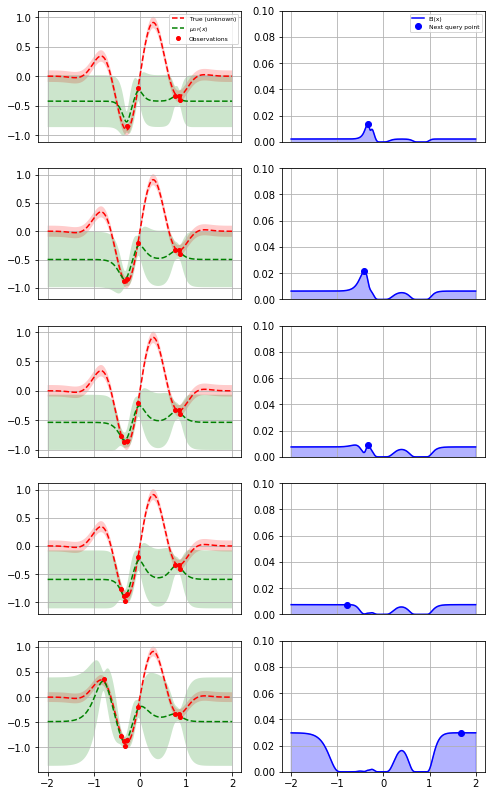

In [56]:
from skopt.acquisition import gaussian_ei

plt.rcParams["figure.figsize"] = (8, 14)

x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())
fx = np.array([f(x_i, noise_level=0.0) for x_i in x])

# Plot the 5 iterations following the 5 random points
for n_iter in range(5):
    gp = res.models[n_iter]
    curr_x_iters = res.x_iters[:5+n_iter]
    curr_func_vals = res.func_vals[:5+n_iter]

    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")

    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom=False, 
                        top=False, labelbottom=False) 


    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    acq = gaussian_ei(x_gp, gp, y_opt=np.min(curr_func_vals))
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')

    next_x = res.x_iters[5+n_iter]
    next_acq = gaussian_ei(res.space.transform([next_x]), gp, y_opt=np.min(curr_func_vals))
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")

    # Adjust plot layout
    plt.ylim(0, 0.1)
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom=False, 
                        top=False, labelbottom=False) 

plt.show()


The first column shows the following:

- The true function.
- The approximation to the original function by the gaussian process model
- How sure the GP is about the function.


The second column shows the acquisition function values after every surrogate model is fit. It is possible that we do not choose the global minimum but a local minimum depending on the minimizer used to minimize the acquisition function.


At the points closer to the points previously evaluated at, the variance dips to zero.

Finally, as we increase the number of points, the GP model approaches the actual function. The final few points are clustered around the minimum because the GP does not gain anything more by further exploration:




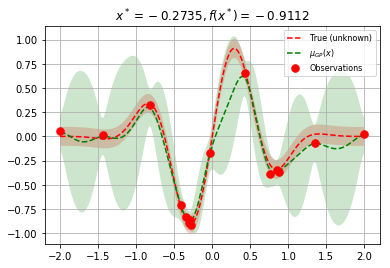

In [180]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())

fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

# Plot GP(x) + contours
gp = res.models[-1]*
y_pred, sigma = gp.predict(x_gp, return_std=True)

plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma, 
                         (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc="g", ec="None")

# Plot sampled points
plt.plot(res.x_iters,
         res.func_vals,
         "r.", markersize=15, label="Observations")

plt.title(r"$x^* = %.4f, f(x^*) = %.4f$" % (res.x[0], res.fun))
plt.legend(loc="best", prop={'size': 8}, numpoints=1)
plt.grid()

plt.show()

## ASk an tell API

## Skopt.space


- What is the sensible way to encode the params that are "continuous but with restrictions"?

- Should spconfparams be discretized even if they are continuous?

In [72]:
import skopt.space 
from skopt.space import Real, Integer, Categorical

In [63]:
p1 = Real(low=1,    high=25, name=)
p2 = Real(low=1,    high=50, name=)
p3 = Integer(low=1, high=8,  name=)

#### for each workload retrieve phases

### Having a prior over configuration values

Could we predict what convinations of hyperparameters would work well on an application given the prior information about the applicaiton? (we run it once).

